In [2]:
import sys
import os.path as op
import shutil
from glob import glob
from importlib import reload
from collections import OrderedDict as od
import numpy as np
from scipy.io import loadmat
from matplotlib.backends.backend_pdf import PdfPages

# Personal code
sys.path.append('/Users/danielschonhaut/penn/lab/code/projects')
from time_cells import spike_sorting

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

In [12]:
# Rename files if necessary.
if False:
    subj_sess = 'U532_ses0'

    subj, sess = subj_sess.split('_')
    subj_dir = op.join('/Users/danielschonhaut/penn/lab/projects/time_cells/data', subj, sess)
    spikes_dir = op.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand')

    files = glob(op.join(spikes_dir, '*_removepli*'))
    print(len(files))
    for f in files:
        dname, fname = op.split(f)
        shutil.move(f, op.join(dname, fname.replace('_removepli', '')))

5


In [53]:
# Load wave_clus outputs for the session.
subj_sess = 'U532_ses0'

subj, sess = subj_sess.split('_')
subj_dir = op.join('/Users/danielschonhaut/penn/lab/projects/time_cells/data', subj, sess)
spikes_dir = op.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand')

output = spike_sorting.compile_wave_clus(subj_sess, verbose=True)
wave_clus, neurons, lfp_timestamps, sr, session_dur_ms, mont, rois = output

Conversion factor is 1
128221050 timestamps over 71 min and 14.0 s
Sampling rate is 30000 Hz
64 electrodes in 7 regions.
RAH: [1 2 3 4 5 6 7 8]
RA: [ 9 10 11 12 13 14 15 16]
RFSG: [17 18 19 20 21 22 23 24]
LAH: [33 34 35 36 37 38 39 40]
LA: [41 42 43 44 45 46 47 48]
LFSG: [49 50 51 52 53 54 55 56]
LOF: [57 58 59 60 61 62 63 64]
65 neurons


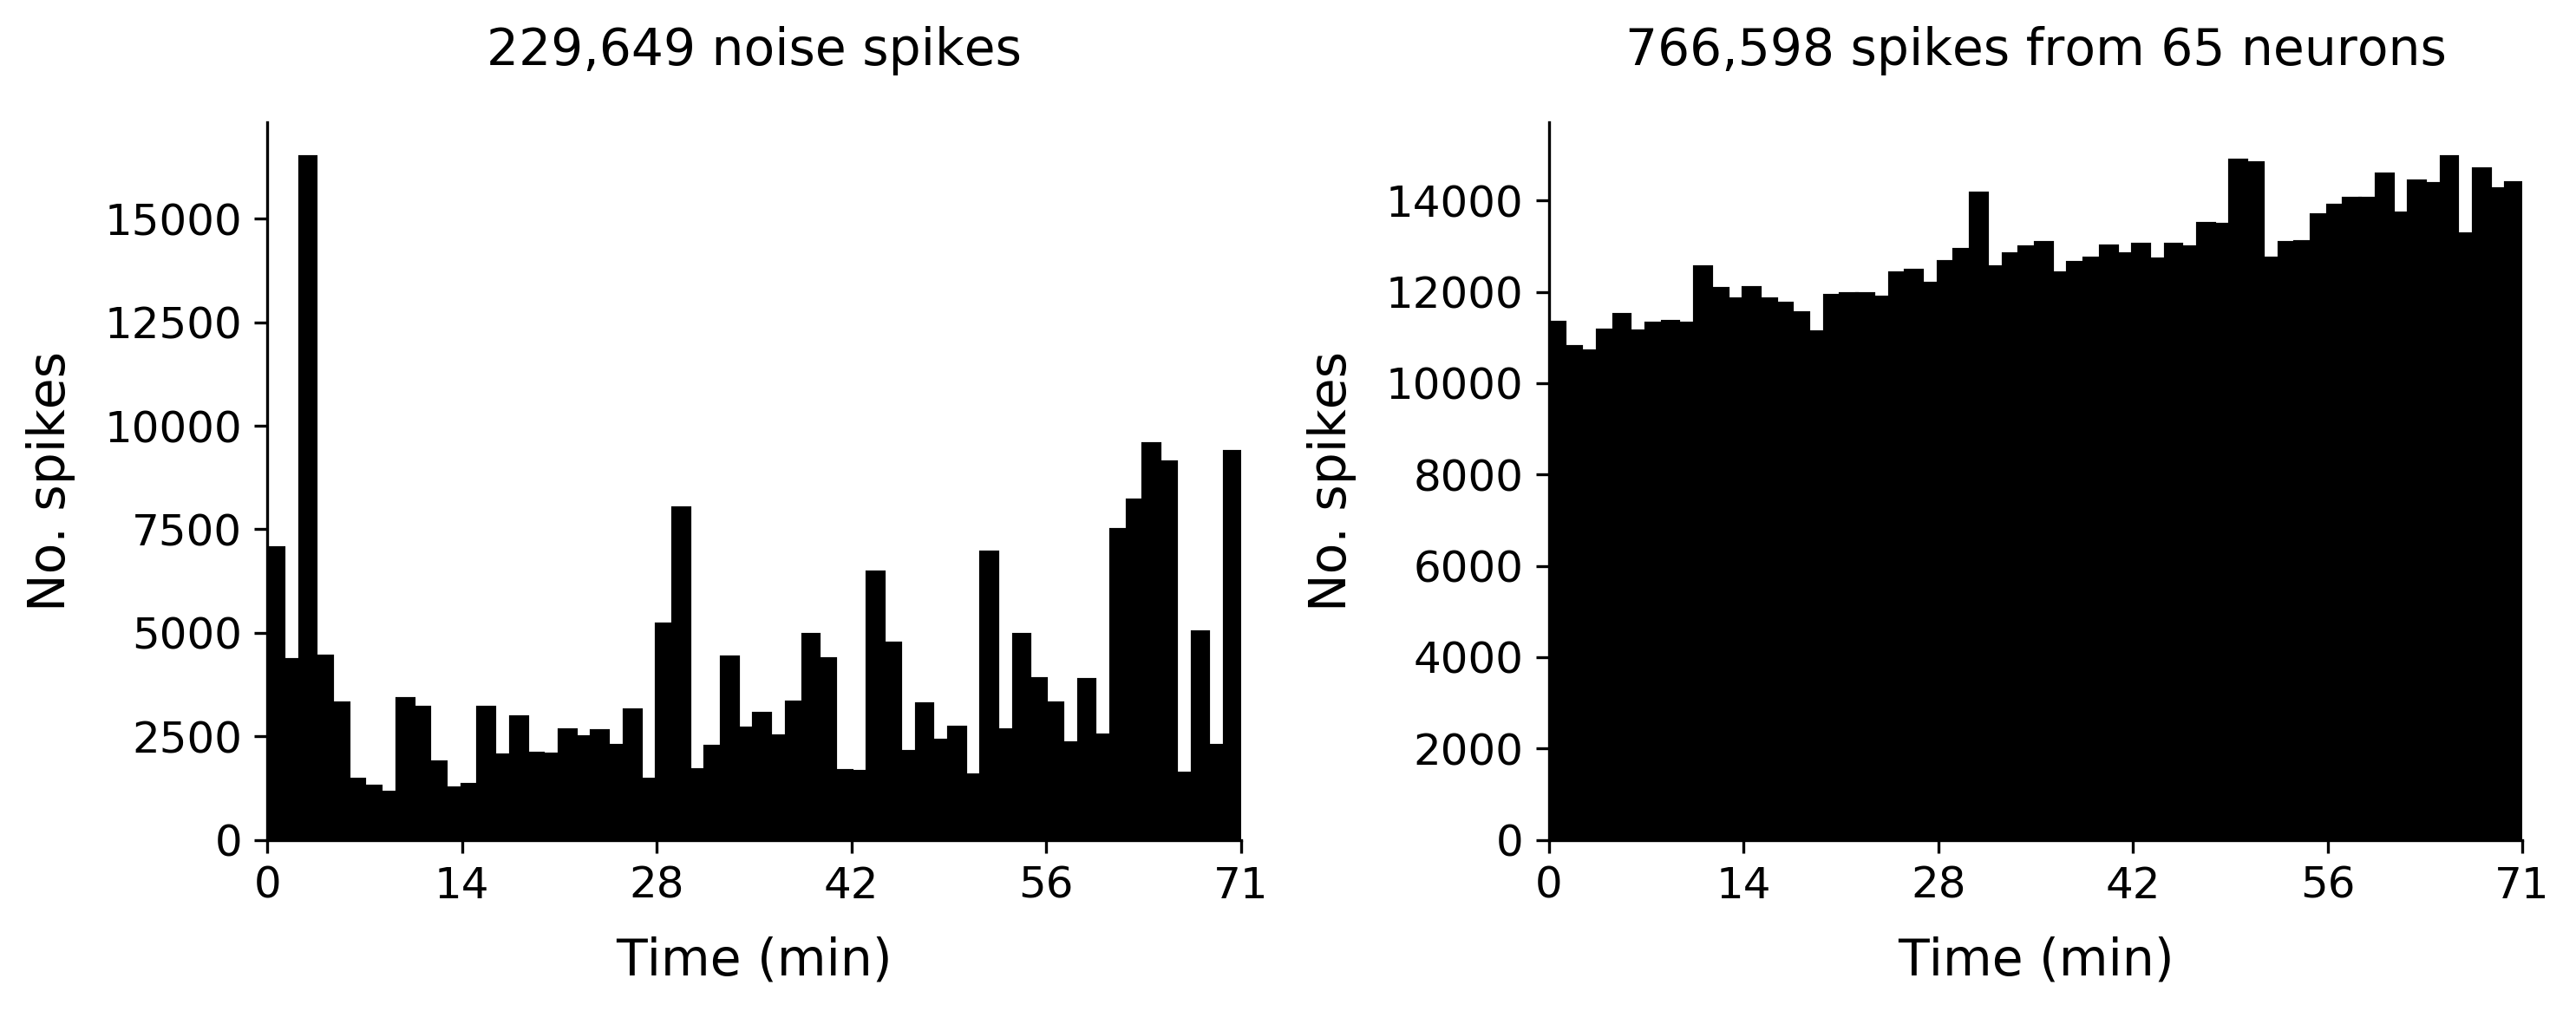

In [54]:
# Plot average spiking over session time across all microelectrodes.
noise_spike_times = []
neuron_spike_times = []
chans = np.array(list(mont.values())).flatten()
n_neurons = 0
for chan in chans:
    wave_clusf = op.join(spikes_dir, 'times_CSC{}.mat'.format(chan))
    if op.exists(wave_clusf):
        dat = loadmat(wave_clusf)['cluster_class']
        noise_spike_times.extend(list(dat[np.where(dat[:, 0]==0)[0], 1]))
        neuron_spike_times.extend(list(dat[np.where(dat[:, 0]!=0)[0], 1]))
        n_neurons += len(np.unique(dat[np.where(dat[:, 0]!=0)[0], 0]))
        
noise_spike_times = np.array(noise_spike_times)
neuron_spike_times = np.array(neuron_spike_times)
xmin, xmax = np.min(noise_spike_times), np.max(noise_spike_times)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

i = 0
if len(noise_spike_times)>0:
    ax[i].hist(noise_spike_times, bins=60, alpha=1, color='k', edgecolor='k')
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_xticks(np.linspace(xmin, xmax, 6))
    ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=font['tick'])
    ax[i].set_xlabel('Time (min)', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('No. spikes', fontsize=font['label'], labelpad=8)
ax[i].set_title('{:,d} noise spikes'.format(len(noise_spike_times)), 
                fontsize=font['label'], y=1.05)

i = 1
if len(neuron_spike_times)>0:
    ax[i].hist(neuron_spike_times, bins=60, alpha=1, color='k', edgecolor='k')
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_xticks(np.linspace(xmin, xmax, 6))
    ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=font['tick'])
    ax[i].set_xlabel('Time (min)', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('No. spikes', fontsize=font['label'], labelpad=8)
ax[i].set_title('{:,d} spikes from {:,d} neurons'.format(len(neuron_spike_times), n_neurons), 
                fontsize=font['label'], y=1.05)

fig.tight_layout()

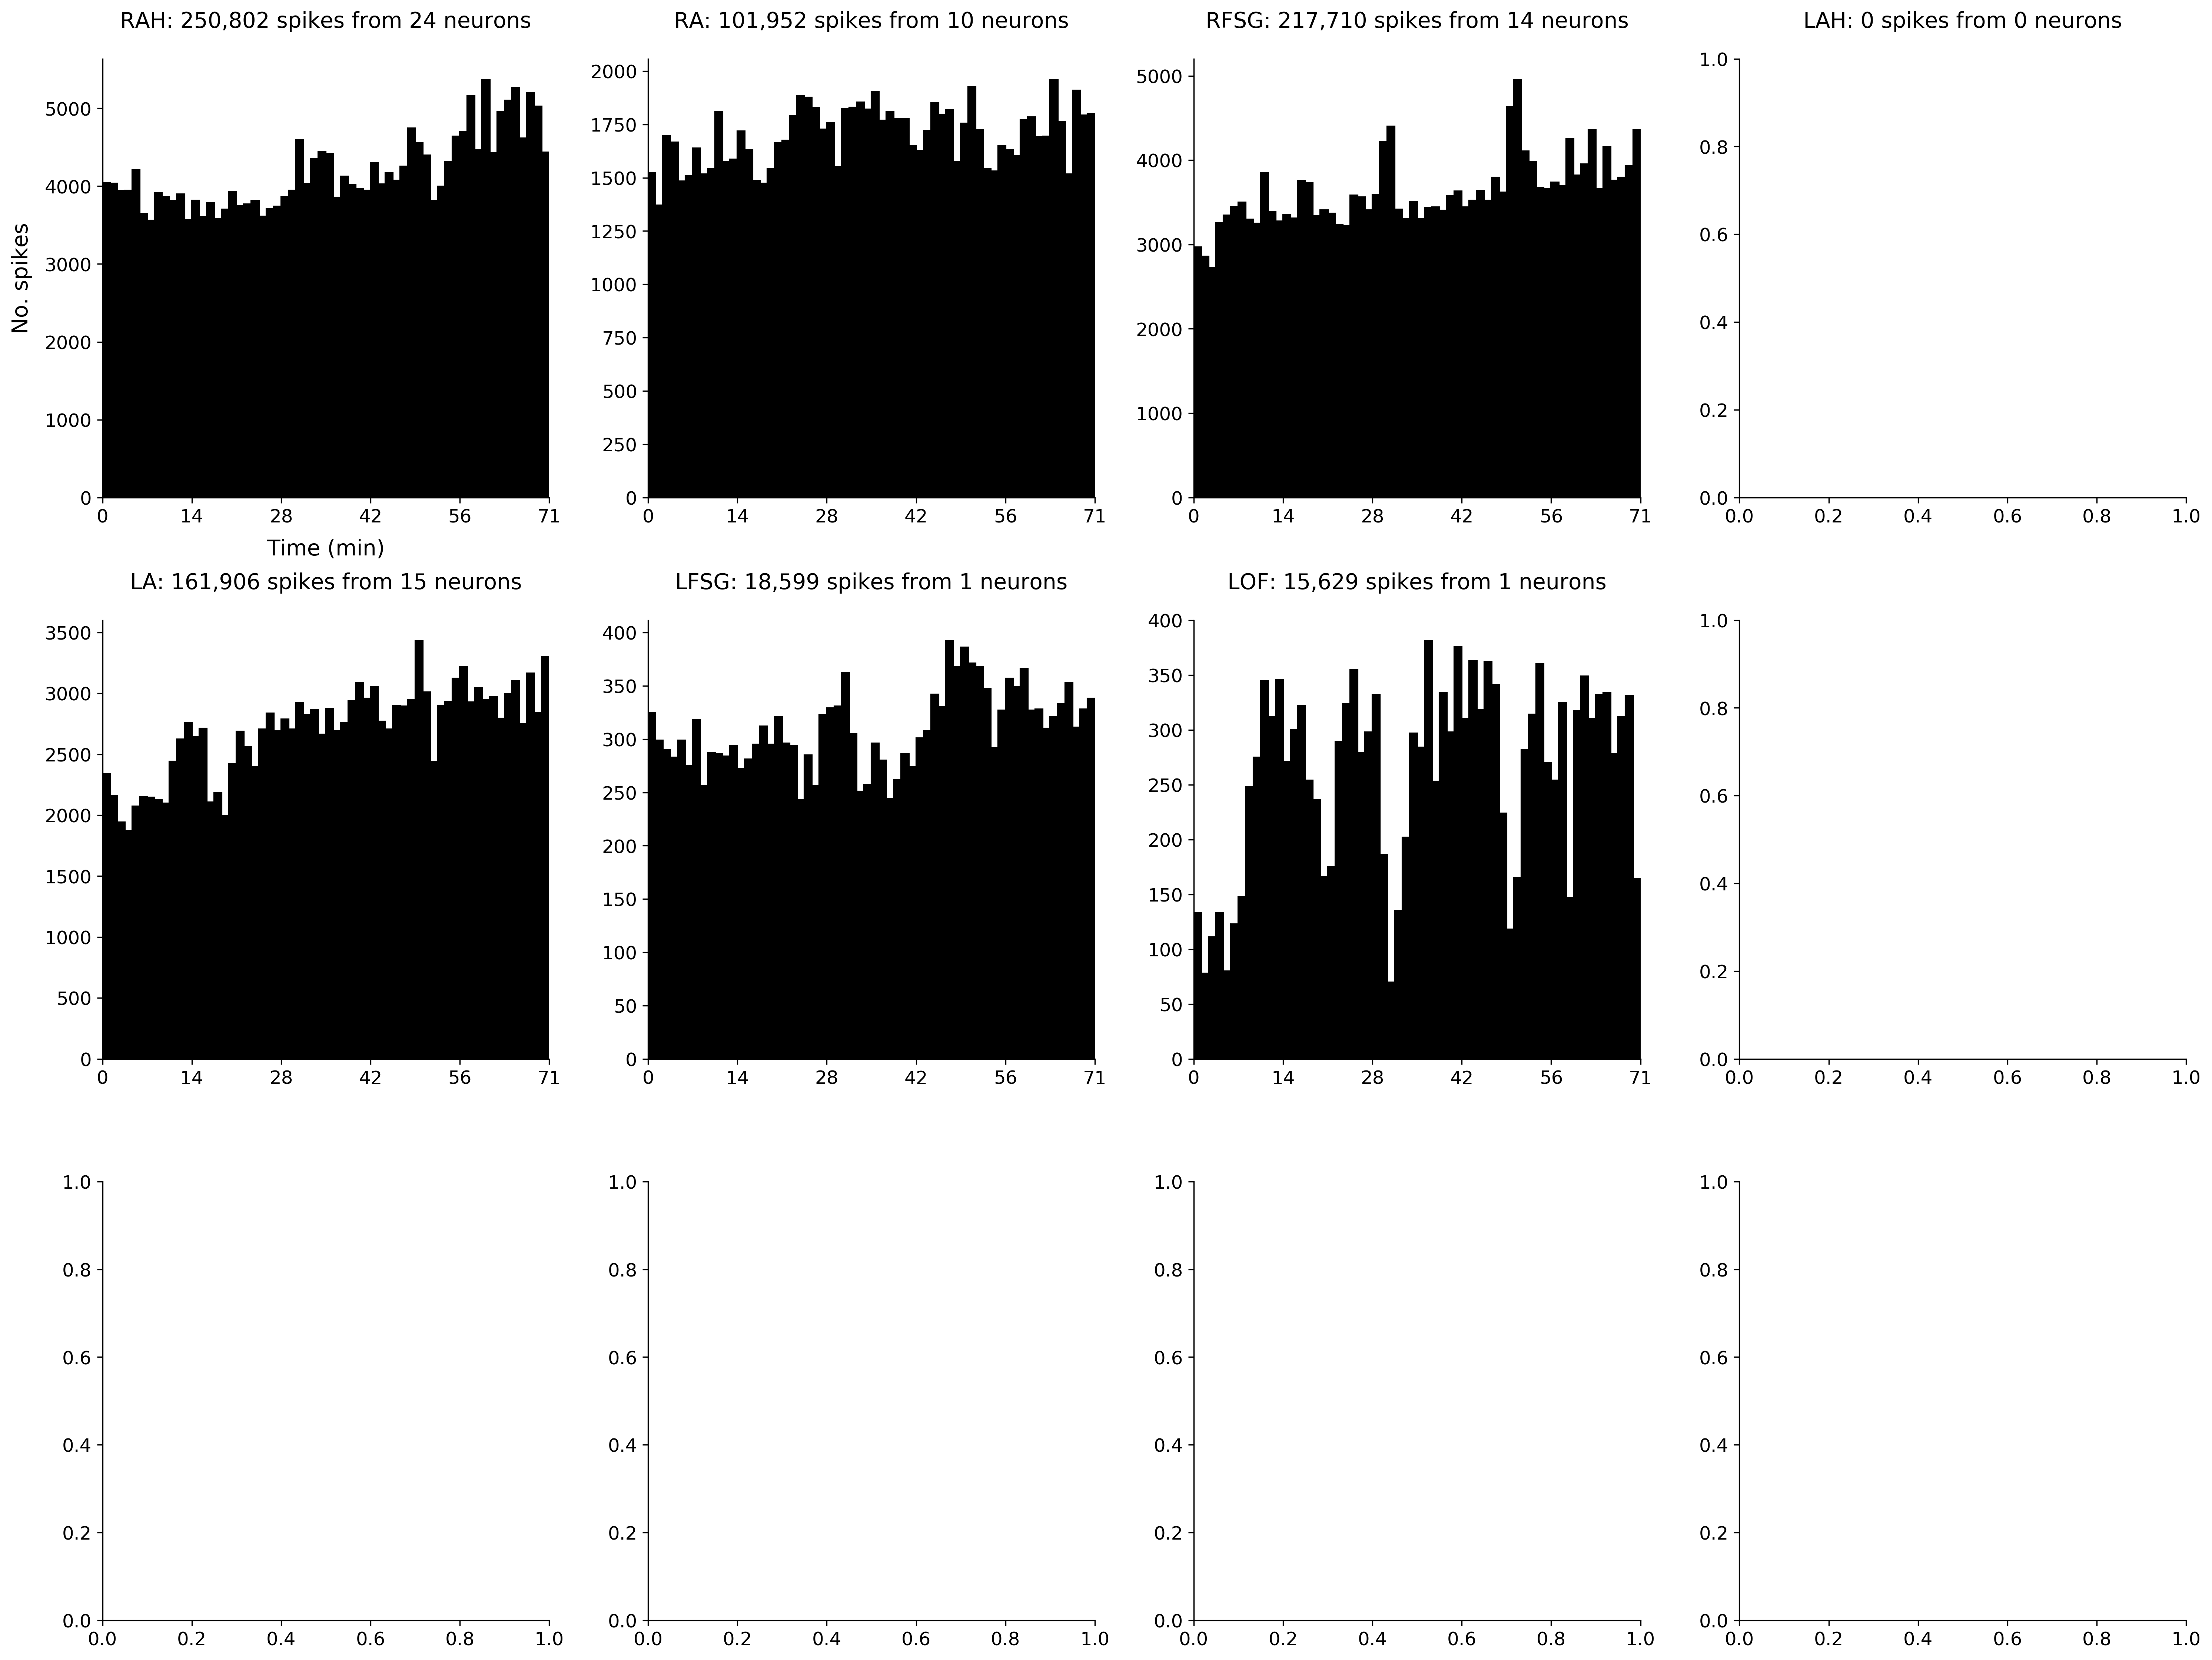

In [55]:
# Plot average spiking over session time, within each region.
fig, ax = plt.subplots(3, 4, figsize=(20, 15), dpi=300)
ax = np.ravel(ax)

spike_times = od([])
for roi in rois:    
    chans = mont[roi]
    spike_times_ = []
    n_neurons = 0
    for chan in chans:
        wave_clusf = op.join(spikes_dir, 'times_CSC{}.mat'.format(chan))
        if op.exists(wave_clusf):
            dat = loadmat(wave_clusf)['cluster_class']
            neuron_inds = np.where(dat[:, 0]!=0)[0]
            spike_times_.extend(list(dat[neuron_inds, 1]))
            n_neurons += len(np.unique(dat[neuron_inds, 0]))
    spike_times[roi] = [spike_times_, n_neurons]

for i in range(len(rois)):
    roi = rois[i]
    if spike_times[roi][0]:
        xmin, xmax = np.min(spike_times[roi][0]), np.max(spike_times[roi][0])
        ax[i].hist(spike_times[roi][0], bins=60, alpha=1, color='k', edgecolor='k')
        ax[i].set_xlim(xmin, xmax)
        ax[i].set_xticks(np.linspace(xmin, xmax, 6))
        ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=font['tick'])
        if i == 0:
            ax[i].set_xlabel('Time (min)', fontsize=font['label'], labelpad=8)
            ax[i].set_ylabel('No. spikes', fontsize=font['label'], labelpad=8)
    ax[i].set_title('{}: {:,d} spikes from {:,d} neurons'.format(roi, len(spike_times[roi][0]), spike_times[roi][1]), 
                    fontsize=font['label'], y=1.05)

fig.tight_layout()

Unit 0: 915 spikes
Unit 1: 18599 spikes


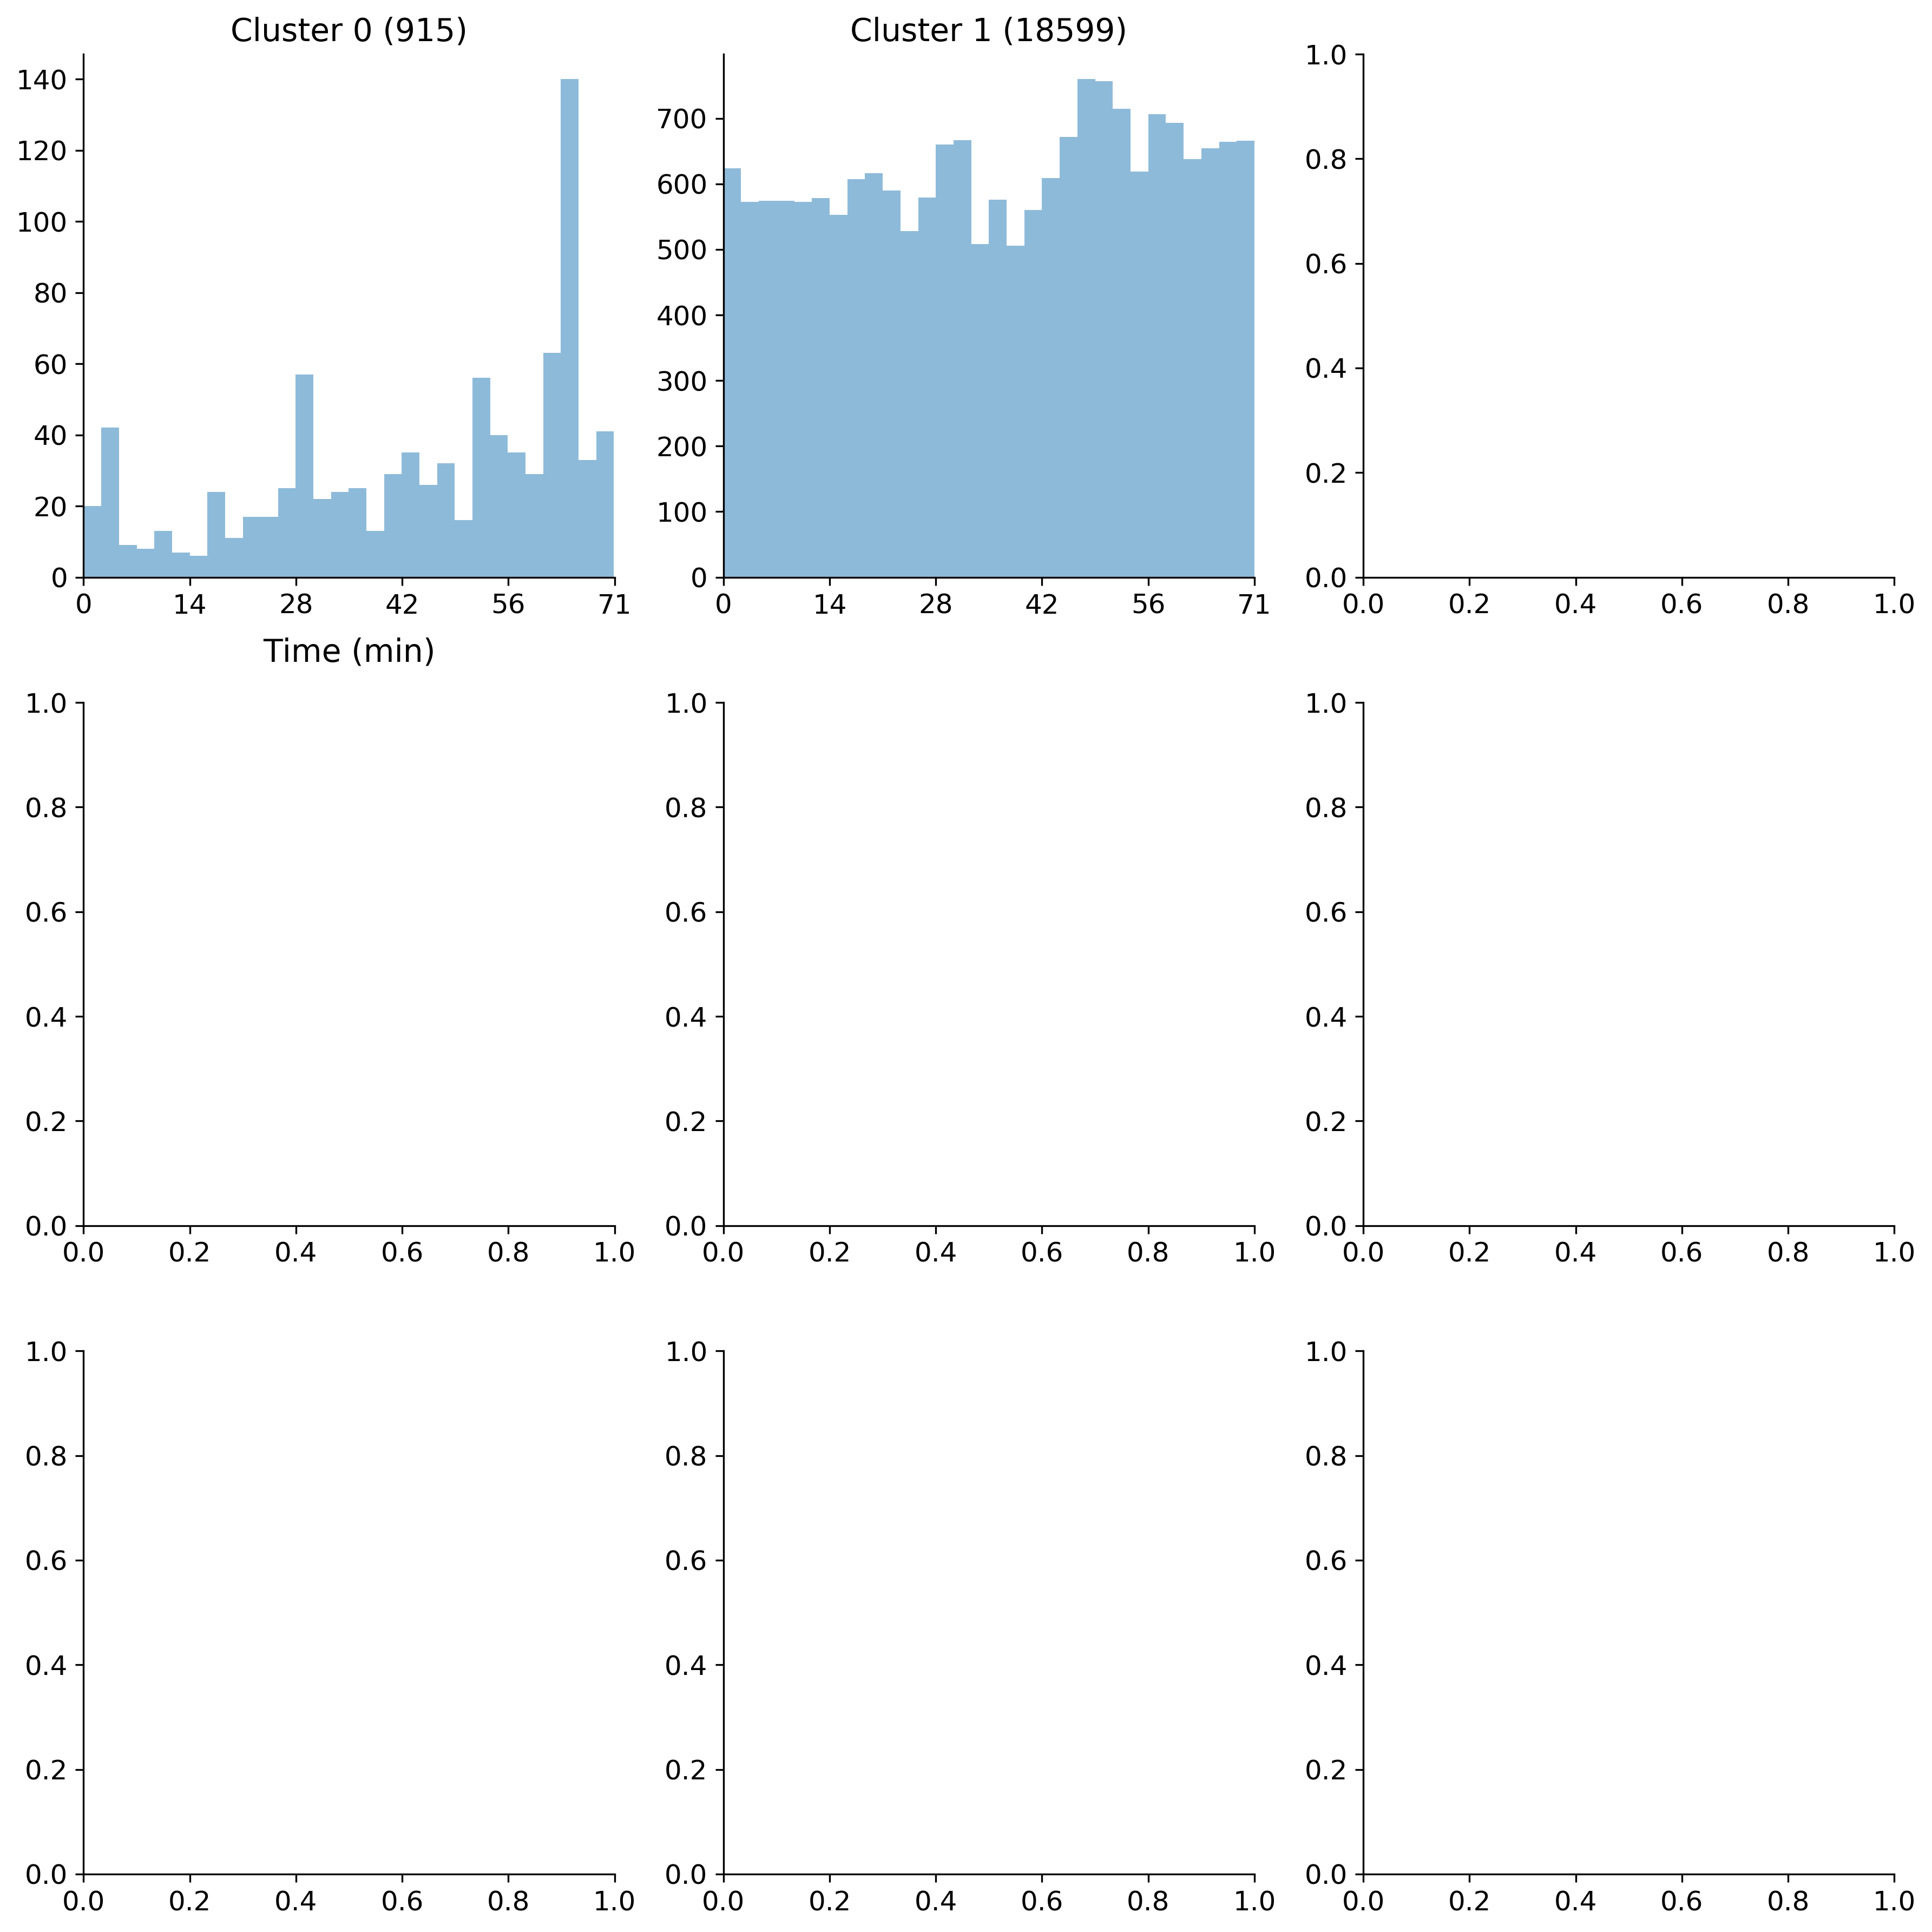

In [52]:
# Plot spiking over session time for each unit, for a chosen channel.
chan = 53
# -----------------------

wave_clusf = op.join(spikes_dir, 'times_CSC{}.mat'.format(chan))
if op.exists(wave_clusf):
    dat = loadmat(wave_clusf)['cluster_class']
    units, nspikes = np.unique(dat[:,0], return_counts=True)
    for i in range(len(units)):
        print('Unit {:.0f}: {} spikes'.format(units[i], nspikes[i]))
else:
    print('Missing {}'.format(wave_clusf))
    
fig, ax = plt.subplots(3, 3, figsize=(12, 12), dpi=300)
ax = np.ravel(ax)

xmin, xmax = np.min(dat[:, 1]), np.max(dat[:, 1])
i = 0
for unit in units:
    dat_ = dat[np.where(dat==unit)[0], :]
    ax[i].hist(dat_[:, 1], bins=30, alpha=0.5)
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_xticks(np.linspace(xmin, xmax, 6))
    ax[i].set_xticklabels(np.linspace(xmin/6e4, xmax/6e4, 6, dtype=int), fontsize=font['tick'])
    ax[i].set_title('Cluster {:.0f} ({})'.format(unit, len(dat_)), fontsize=font['label'])
    if i == 0:
        ax[i].set_xlabel('Time (min)', fontsize=font['label'])
    else:
        ax[i].set_xlabel('')
    i += 1
    
fig.tight_layout()

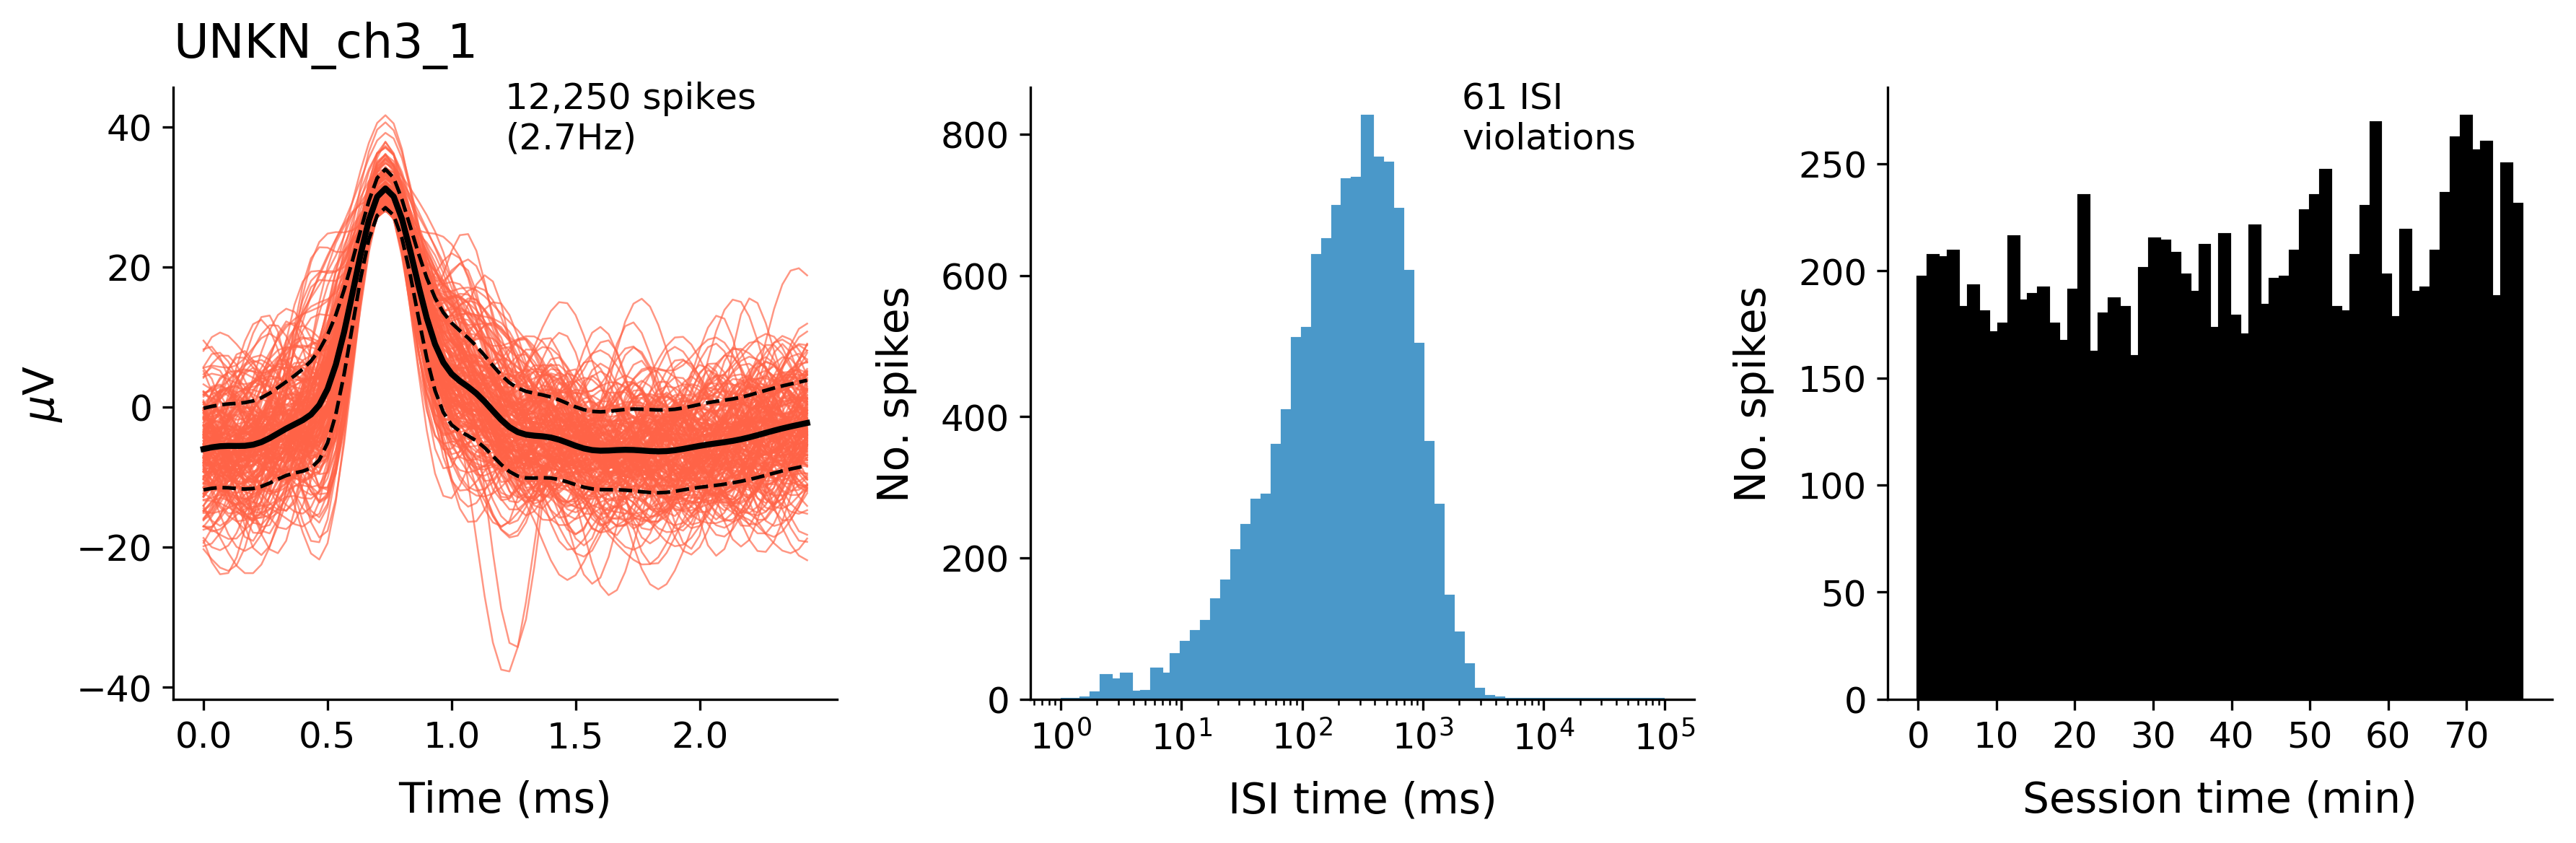

In [26]:
# Generate plots from wave_clus outputs for a chosen unit.
iNeuron = 2

neuron = neurons[iNeuron]
fig, ax = spike_sorting.plot_neuron3(wave_clus, neuron, sr, session_dur_ms, 'log')

In [56]:
# Generate spike stat plots from wave_clus outputs for each unit in the session.
output_f = op.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand',
                   '{}_neuron_plots.pdf'.format(subj_sess))

fig, ax = plt.subplots(8, 6, figsize=(24, 32), dpi=300)
ax = np.ravel(ax)
with PdfPages(output_f) as pdf:
    for iNeuron in range(len(neurons)):
        neuron = neurons[iNeuron]
        neuron_dat = wave_clus[neuron]
        i = (iNeuron % 16) * 3
        label_axes = True if (i == 0) else False
        
        ax[i] = spike_sorting.plot_waveforms(neuron_dat, 
                                             sr, 
                                             ax[i],
                                             label_axes=label_axes,
                                             fontsize=font)
        ax[i].set_title(neuron, fontsize=font['fig'], y=1.02, loc='left')
        
        i += 1
        ax[i] = spike_sorting.plot_isi_hist(neuron_dat,
                                            ax[i],
                                            color=colors[0],
                                            label_axes=label_axes,
                                            fontsize=font)
        
        i += 1
        ax[i] = spike_sorting.plot_spike_stability(neuron_dat, 
                                                   session_dur_ms, 
                                                   ax[i],
                                                   label_axes=label_axes,
                                                   fontsize=font)
        
        if (iNeuron % 16 == 15) and (iNeuron + 1 < len(neurons)):
            fig.tight_layout(h_pad=1.12, w_pad=1.12)
            pdf.savefig(fig, bbox_inches='tight', pad_inches=1)
            plt.close(fig)
            fig, ax = plt.subplots(8, 6, figsize=(24, 32), dpi=300)
            ax = np.ravel(ax)
    
    fig.tight_layout(h_pad=1.12, w_pad=1.12)
    pdf.savefig(fig, bbox_inches='tight', pad_inches=1)